In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [1]:
import pandas as pd

# Use the correct path for the Kaggle dataset
df = pd.read_csv('/kaggle/input/raw-dataset/raw_dataset.csv')

# Continue with the rest of the processing
df_sampled = df.sample(n=14000, random_state=42)
df_sampled.to_csv('new_dataset.csv', index=False)


In [2]:
# Save the reduced dataset to a new CSV file
df_sampled.to_csv('/kaggle/working/new_dataset.csv', index=False)

# Print a message to confirm the location
print("The new dataset is saved as 'new_dataset.csv' in the output directory.")

The new dataset is saved as 'new_dataset.csv' in the output directory.


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import joblib
import boto3
import warnings

# Suppress FutureWarnings if necessary (optional)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
def handle_duplicates(dataframe):
    print("Number of duplicate rows before dropping: ", dataframe.duplicated().sum())
    dataframe.drop_duplicates(inplace=True)
    print("Number of duplicate rows after dropping: ", dataframe.duplicated().sum())

handle_duplicates(df)

Number of duplicate rows before dropping:  0
Number of duplicate rows after dropping:  0


In [5]:
def handle_missing_values(dataframe):
    missing_values_summary = dataframe.isnull().sum()
    print("\nMissing Values Summary:\n", missing_values_summary)
    
    # Handle missing values
    for column in dataframe.columns:
        if dataframe[column].dtype in ['int64', 'float64']:
            median_value = dataframe[column].median()
            dataframe[column] = dataframe[column].fillna(median_value)  # No inplace=True to avoid warning
        elif dataframe[column].dtype == 'object':
            mode_value = dataframe[column].mode()[0]
            dataframe[column] = dataframe[column].fillna(mode_value)  # No inplace=True to avoid warning
    print("\nAfter Handling Missing Values:\n", dataframe.isnull().sum())

handle_missing_values(df)


Missing Values Summary:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

After Handling Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [6]:
def drop_unnecessary_columns(dataframe, columns):
    dataframe.drop(columns=columns, inplace=True)
    print("Dropped unnecessary columns: ", columns)

columns_to_drop = ['step', 'nameOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
drop_unnecessary_columns(df, columns_to_drop)

Dropped unnecessary columns:  ['step', 'nameOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']


In [7]:
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
print("Categorical features converted to numerical format.")

# Map Categorical Name for 'isFraud' Column
# Update the 'isFraud' column to represent classes with labels for better interpretability
df["isFraud"] = df["isFraud"].map({
    0: "No Fraud", 1: "Fraud"
})
print("Updated 'isFraud' column with categorical labels.")

df.head(10)

Categorical features converted to numerical format.
Updated 'isFraud' column with categorical labels.


,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,3,9839.64,170136.00,160296.36,No Fraud
1,3,1864.28,21249.00,19384.72,No Fraud
2,4,181.00,181.00,0.00,Fraud
3,1,181.00,181.00,0.00,Fraud
4,3,11668.14,41554.00,29885.86,No Fraud
5,3,7817.71,53860.00,46042.29,No Fraud
6,3,7107.77,183195.00,176087.23,No Fraud
7,3,7861.64,176087.23,168225.59,No Fraud
8,3,4024.36,2671.00,0.00,No Fraud
9,2,5337.77,41720.00,36382.23,No Fraud


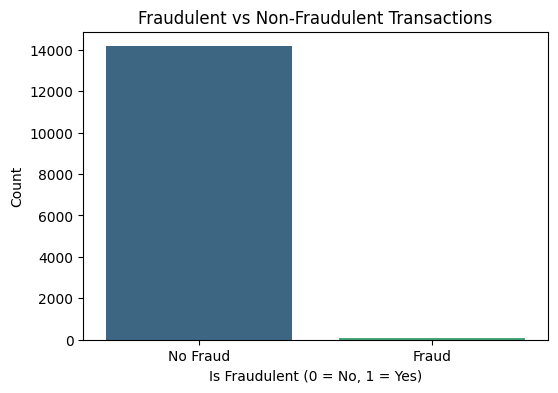


Fraudulent Transaction Summary:
 isFraud
No Fraud    14164
Fraud          78
Name: count, dtype: int64



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def check_balance(dataframe):
    """
    Displays the distribution of fraudulent vs. non-fraudulent transactions
    and checks for class imbalance in the dataset.
    """
    # Plot fraudulent vs non-fraudulent transactions
    plt.figure(figsize=(6, 4))
    sns.countplot(data=dataframe, x='isFraud', palette='viridis')  # Removed hue to avoid redundancy
    plt.title('Fraudulent vs Non-Fraudulent Transactions')
    plt.xlabel('Is Fraudulent (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.show()

    # Print fraudulent transaction summary
    fraud_count = dataframe['isFraud'].value_counts()
    print("\nFraudulent Transaction Summary:\n", fraud_count)

    # Check for imbalance
    imbalance_ratio = fraud_count.min() / fraud_count.max()
    if imbalance_ratio < 0.1:
        print("\nWarning: The dataset is highly imbalanced. Consider resampling techniques (e.g., SMOTE, oversampling, or undersampling).")

# Call the function with your DataFrame
check_balance(df)


In [9]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import pandas as pd

def show_class_distribution(dataframe, target_column, label):
    """
    Displays the class distribution.
    """
    print(f"\nClass Distribution ({label}):")
    print(dataframe[target_column].value_counts())
    print()

def balance_data_random_oversampling(dataframe, target_column):
    """
    Balances the dataset using random oversampling.
    """
    # Separate majority and minority classes
    majority_class = dataframe[dataframe[target_column] == 0]
    minority_class = dataframe[dataframe[target_column] == 1]
    
    # Oversample the minority class
    minority_oversampled = resample(
        minority_class,
        replace=True,                  # Sample with replacement
        n_samples=len(majority_class), # Match the majority class count
        random_state=42                # Ensure reproducibility
    )
    
    # Combine majority class with oversampled minority class
    balanced_dataframe = pd.concat([majority_class, minority_oversampled])
    return balanced_dataframe

# Display before and after balancing using random oversampling
print("Using Random Oversampling:")
show_class_distribution(df, 'isFraud', "Before Balancing")
balanced_df = balance_data_random_oversampling(df, 'isFraud')
show_class_distribution(balanced_df, 'isFraud', "After Balancing")

def balance_data_smote(features, target):
    """
    Balances the dataset using SMOTE.
    """
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(features, target)
    return X_resampled, y_resampled

# Example with SMOTE
print("\nUsing SMOTE:")
X = df.drop(columns=['isFraud'])
y = df['isFraud']

# Before SMOTE
print("\nClass Distribution (Before SMOTE):")
print(y.value_counts())

# After SMOTE
X_balanced, y_balanced = balance_data_smote(X, y)
print("\nClass Distribution (After SMOTE):")
print(pd.Series(y_balanced).value_counts())


Using Random Oversampling:

Class Distribution (Before Balancing):
isFraud
No Fraud    14164
Fraud          78
Name: count, dtype: int64


Class Distribution (After Balancing):
Series([], Name: count, dtype: int64)


Using SMOTE:

Class Distribution (Before SMOTE):
isFraud
No Fraud    14164
Fraud          78
Name: count, dtype: int64

Class Distribution (After SMOTE):
isFraud
No Fraud    14164
Fraud       14164
Name: count, dtype: int64


In [10]:
print("Balanced Class Distribution:")
print(pd.Series(y_balanced).value_counts())


Balanced Class Distribution:
isFraud
No Fraud    14164
Fraud       14164
Name: count, dtype: int64


In [11]:
final_dataset_path = "Final_cleaned_preprocessed_dataset.csv"
df.to_csv(final_dataset_path, index=False)
print("Final preprocessed dataset saved to: ", final_dataset_path)

Final preprocessed dataset saved to:  Final_cleaned_preprocessed_dataset.csv


In [12]:


file_path = r"/kaggle/input/final-preprocessed-dataseat/Final_cleaned_preprocessed_dataset.csv"

try:
    data = pd.read_csv(file_path)
    print("Data loaded successfully.")
    print(data.head())  # Display the first few rows of the dataset
except FileNotFoundError:
    print("File not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")


Data loaded successfully.
   type    amount  oldbalanceOrg  newbalanceOrig   isFraud
0     3   9839.64       170136.0       160296.36  No Fraud
1     3   1864.28        21249.0        19384.72  No Fraud
2     4    181.00          181.0            0.00     Fraud
3     1    181.00          181.0            0.00     Fraud
4     3  11668.14        41554.0        29885.86  No Fraud


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    silhouette_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope

# Load your preprocessed data
data = pd.read_csv('/kaggle/input/final-preprocessed-dataseat/Final_cleaned_preprocessed_dataset.csv')

# Print the column names
print("Available columns:")
print(data.columns)

# Print the first few rows of the data
print("\nFirst few rows of the data:")
print(data.head())


Available columns:
Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'isFraud'], dtype='object')

First few rows of the data:
   type    amount  oldbalanceOrg  newbalanceOrig   isFraud
0     3   9839.64       170136.0       160296.36  No Fraud
1     3   1864.28        21249.0        19384.72  No Fraud
2     4    181.00          181.0            0.00     Fraud
3     1    181.00          181.0            0.00     Fraud
4     3  11668.14        41554.0        29885.86  No Fraud


In [15]:
# Select features and target variable
X = data[['amount', 'oldbalanceOrg', 'newbalanceOrig']]
y = data['isFraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset
# Assuming your data is in a DataFrame named 'data'

# Convert categorical 'type' column into dummy variables
data = pd.get_dummies(data, columns=['type'], prefix='type')

# Define features and target variable
X = data[['amount', 'oldbalanceOrg', 'newbalanceOrig']]
y = data['isFraud'].map({'No Fraud': 0, 'Fraud': 1})  # Convert target to binary

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the scaled datasets
print("Shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Shapes:
X_train_scaled: (11393, 3)
X_test_scaled: (2849, 3)
y_train: (11393,)
y_test: (2849,)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


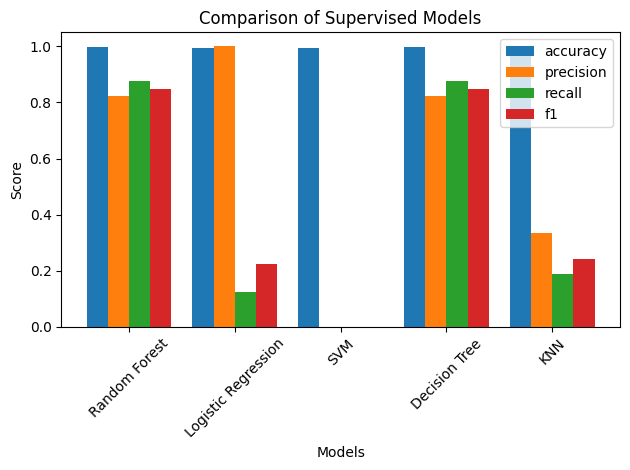


Results:

Random Forest:
accuracy: 0.9982
precision: 0.8235
recall: 0.8750
f1: 0.8485

Logistic Regression:
accuracy: 0.9951
precision: 1.0000
recall: 0.1250
f1: 0.2222

SVM:
accuracy: 0.9944
precision: 0.0000
recall: 0.0000
f1: 0.0000

Decision Tree:
accuracy: 0.9982
precision: 0.8235
recall: 0.8750
f1: 0.8485

KNN:
accuracy: 0.9933
precision: 0.3333
recall: 0.1875
f1: 0.2400

K-Means:
silhouette: 0.8034
accuracy: 0.8917

DBSCAN:
silhouette: 0.0000

PCA:
explained_variance_ratio: 0.9990


In [18]:
# Dictionary to store results
results = {}

# Function to evaluate supervised models
def evaluate_supervised_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

# Supervised Models
supervised_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Evaluate supervised models
for name, model in supervised_models.items():
    results[name] = evaluate_supervised_model(model, X_train_scaled, X_test_scaled, y_train, y_test)

# Unsupervised Models
# K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train_scaled)
results['K-Means'] = {
    'silhouette': silhouette_score(X_train_scaled, kmeans_labels),
    'accuracy': accuracy_score(y_train, kmeans_labels)
}

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_train_scaled)
valid_points = dbscan_labels != -1
results['DBSCAN'] = {
    'silhouette': silhouette_score(X_train_scaled[valid_points], dbscan_labels[valid_points])
    if len(np.unique(dbscan_labels[valid_points])) > 1 else 0
}

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
results['PCA'] = {
    'explained_variance_ratio': sum(pca.explained_variance_ratio_)
}


# Supervised Models Comparison
metrics = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(supervised_models))
width = 0.2

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in supervised_models]
    plt.bar(x + i*width, values, width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Supervised Models')
plt.xticks(x + width*1.5, supervised_models.keys(), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



# Print  results
print("\nResults:")
for model, metrics in results.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")




In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score, confusion_matrix
from joblib import Parallel, delayed
import time
     # Part 1: Setup and Utility Functions
def evaluate_supervised_model(model, param_grid, X_train, X_test, y_train, y_test, cv=3, n_iter=10):
    search = RandomizedSearchCV(model, param_grid, n_iter=n_iter, cv=cv, n_jobs=-1, scoring='f1', verbose=1)

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    return {
        'best_params': search.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

def evaluate_model(name, model, param_grid):
    print(f"Evaluating {name}...")
    return name, evaluate_supervised_model(model, param_grid, X_train_scaled, X_test_scaled, y_train, y_test)

    

In [23]:
# Part 2: Supervised Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

supervised_models = {
    'Random Forest': (RandomForestClassifier(random_state=42),
                      {'n_estimators': randint(50, 300),
                       'max_depth': [None, 10, 20, 30],
                       'min_samples_split': randint(2, 11)}),
    'Logistic Regression': (LogisticRegression(random_state=42, max_iter=1000),
                            {'C': uniform(0.1, 10),
                             'penalty': ['l1', 'l2']}),
    'SVM': (SVC(random_state=42),
            {'C': uniform(0.1, 10),
             'kernel': ['rbf', 'linear']}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42),
                      {'max_depth': [None, 10, 20, 30],
                       'min_samples_split': randint(2, 11)}),
    'KNN': (KNeighborsClassifier(),
            {'n_neighbors': randint(3, 10),
             'weights': ['uniform', 'distance']})
}

In [24]:
# Part 3: Evaluate Supervised Models
start_time = time.time()
results = dict(Parallel(n_jobs=-1)(delayed(evaluate_model)(name, model, param_grid)
                                   for name, (model, param_grid) in supervised_models.items()))
print(f"Supervised models evaluation completed in {time.time() - start_time:.2f} seconds")


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Supervised models evaluation completed in 26.50 seconds


In [28]:
# Store old results for comparison
old_results = {
    'Random Forest': {'accuracy': 0.9908, 'precision': 0.9881, 'recall': 0.9935, 'f1': 0.9908},
    'Logistic Regression': {'accuracy': 0.9446, 'precision': 0.9142, 'recall': 0.9812, 'f1': 0.9465},
    'SVM': {'accuracy': 0.9277, 'precision': 0.8852, 'recall': 0.9824, 'f1': 0.9313},
    'Decision Tree': {'accuracy': 0.9897, 'precision': 0.9864, 'recall': 0.9930, 'f1': 0.9897},
    'KNN': {'accuracy': 0.9895, 'precision': 0.9847, 'recall': 0.9945, 'f1': 0.9896}
}

# Print results
print("\nResults:")
print("-" * 50)
for model_name, model_results in results.items():
    print(f"\n{model_name}:")
    print(f"Best Parameters: {model_results['best_params']}")
    print(f"Accuracy: {model_results['accuracy']:.4f}")
    if 'precision' in model_results:
        print(f"Precision: {model_results['precision']:.4f}")
        print(f"Recall: {model_results['recall']:.4f}")
        print(f"F1 Score: {model_results['f1']:.4f}")


# Calculate and display improvements (excluding K-Means)
print("\nPerformance Improvements:")
print("-" * 50)
for model in old_results.keys():
    if model != 'K-Means':
        print(f"\n{model}:")
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            old_value = old_results[model][metric]
            new_value = results[model][metric]
            improvement = new_value - old_value
            print(f"{metric}: {improvement:+.4f} ({improvement/old_value*100:+.2f}%)")



# Find the best performing model (excluding K-Means)
best_model = max((item for item in results.items() if item[0] != 'K-Means'), key=lambda x: x[1]['f1'])
print(f"\nBest Performing Model: {best_model[0]}")
print(f"Best Parameters: {best_model[1]['best_params']}")
print(f"F1 Score: {best_model[1]['f1']:.4f}")

# Save the best model's parameters
best_params = best_model[1]['best_params']
best_model_name = best_model[0]

# Optional: Create confusion matrices for each model (excluding K-Means)
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrices(results, X_test_scaled, y_test):
    n_models = len([model for model in results if model != 'K-Means'])
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()

    idx = 0
    for name, res in results.items():
        if name != 'K-Means':
            # Recreate the model with best parameters and fit it
            model_class = type(supervised_models[name][0])
            best_model = model_class(**res['best_params'])
            best_model.fit(X_train_scaled, y_train)

            y_pred = best_model.predict(X_test_scaled)
            cm = confusion_matrix(y_test, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx])
            axes[idx].set_title(f'{name} Confusion Matrix')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')
            idx += 1

    # Remove empty subplots
    for idx in range(n_models, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()



Results:
--------------------------------------------------

Random Forest:
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 152}
Accuracy: 0.9972
Precision: 0.9972
Recall: 0.9972
F1 Score: 0.9972

Logistic Regression:
Best Parameters: {'C': 3.4767355097306685, 'penalty': 'l2'}
Accuracy: 0.9951
Precision: 0.9951
Recall: 0.9951
F1 Score: 0.9932

SVM:
Best Parameters: {'C': 5.061729823493584, 'kernel': 'rbf'}
Accuracy: 0.9944
Precision: 0.9888
Recall: 0.9944
F1 Score: 0.9916

Decision Tree:
Best Parameters: {'max_depth': 30, 'min_samples_split': 2}
Accuracy: 0.9982
Precision: 0.9983
Recall: 0.9982
F1 Score: 0.9983

KNN:
Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}
Accuracy: 0.9961
Precision: 0.9965
Recall: 0.9961
F1 Score: 0.9963

Performance Improvements:
--------------------------------------------------

Random Forest:
accuracy: +0.0064 (+0.65%)
precision: +0.0091 (+0.92%)
recall: +0.0037 (+0.37%)
f1: +0.0064 (+0.65%)

Logistic Regression:
ac

In [53]:
!pip install --upgrade tensorflow

^C


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

In [30]:
# Get the number of features
n_features = X_train_scaled.shape[1]

# Create the model
model = create_model(n_features)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Print model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 11,841 (46.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [33]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(X_train_scaled, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

# Calculate F1 score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Test F1 score: {test_f1:.4f}")
plt.figure(figsize=(15, 5))



Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9956 - loss: 0.0257 - precision: 0.5288 - recall: 0.0633 - val_accuracy: 0.9930 - val_loss: 0.0343 - val_precision: 0.6667 - val_recall: 0.1176 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9945 - loss: 0.0284 - precision: 0.3659 - recall: 0.0472 - val_accuracy: 0.9930 - val_loss: 0.0291 - val_precision: 0.6667 - val_recall: 0.1176 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9955 - loss: 0.0272 - precision: 0.6907 - recall: 0.1963 - val_accuracy: 0.9930 - val_loss: 0.0313 - val_precision: 0.6667 - val_recall: 0.1176 - learning_rate: 0.0010
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9958 - loss: 0.0207 - precision: 0.5292 - recall: 0.0662 - val_accuracy: 0.9930 - val_loss: 0.0342 - val_precision: 0.6667 - val_recall: 0.1176 - learning_rate: 0.0010
Epoch 5/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Make Predictions and Evaluate Performance:

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2833
           1       1.00      0.12      0.22        16

    accuracy                           1.00      2849
   macro avg       1.00      0.56      0.61      2849
weighted avg       1.00      1.00      0.99      2849



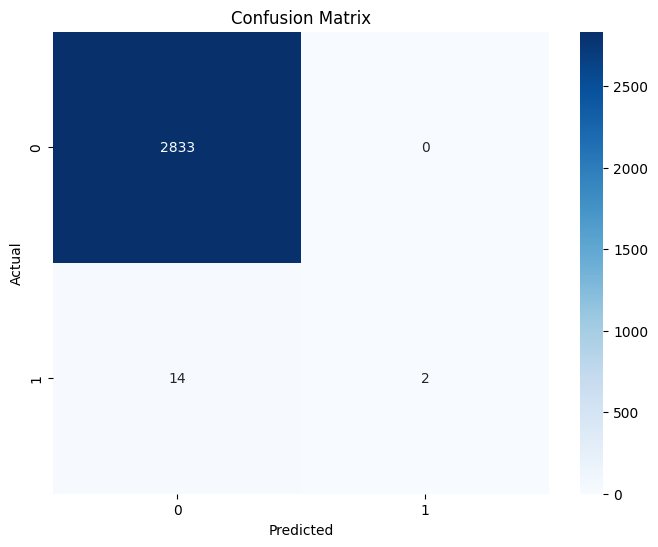

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [68]:
# Save the model
model.save('payment_fraud_detection_model.h5')